In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
import tellurium as te
# import roadrunner
# import antimony
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile

from src.pipeline.dataloader import DataLoaderConfig
from src.pipeline.taskloader import TaskLoaderConfig
from src.settings.strategy import Strategy
from src.settings.tier import Tier

from src.pipeline.dataloader import DataLoader
from src.pipeline.taskloader import TaskFrame, TaskLoader

In [3]:
DataLoader.DATA_FOLDER = './data/training/'
dataloader = DataLoader()
taskloader = TaskLoader()




dataloader.prepare_dataloader(DataLoaderConfig(
    additional_filters=['is_precursor']
))
ann = dataloader.get_dataframe()
df = ann.to_df().join(ann.obs)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f16b5ffa100>>])


In [4]:
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
protein_info

,orf,gene_prefered_name,go_terms,categories,description
0,YAL003W,EFB1,"[GOCC:0005622, GOCC:0005737, GOCC:0005853, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Intracellular, Cytoplasm, Eukaryotic translat..."
1,YAL005C,SSA1,"[GOCC:0000322, GOCC:0000323, GOCC:0000324, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Storage vacuole, Lytic vacuole, Fungal-type v..."
2,YAL007C,ERP2,"[GOCC:0005622, GOCC:0005737, GOCC:0005783, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Intracellular, Cytoplasm, Endoplasmic reticul..."
3,YAL012W,CYS3,"[GOCC:0005576, GOCC:0005622, GOCC:0005634, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Extracellular region, Intracellular, Nucleus,..."
4,YAL035W,FUN12,"[GOCC:0005622, GOCC:0005737, GOCC:0005739, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Intracellular, Cytoplasm, Mitochondrion, Cyto..."
...,...,...,...,...,...
721,YPR165W,RHO1,"[GOCC:0000131, GOCC:0000148, GOCC:0005622, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Incipient cellular bud site, 1,3-beta-D-gluca..."
722,YPR181C,SEC23,"[GOCC:0005622, GOCC:0005737, GOCC:0005783, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Intracellular, Cytoplasm, Endoplasmic reticul..."
723,YPR183W,DPM1,"[GOCC:0005622, GOCC:0005737, GOCC:0005739, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Intracellular, Cytoplasm, Mitochondrion, Mito..."
724,YPR187W,RPO26,"[GOCC:0000428, GOCC:0005622, GOCC:0005634, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[DNA-directed RNA polymerase complex, Intracel..."


In [5]:
protein_info[protein_info['gene_prefered_name'] == 'TDH1']

,orf,gene_prefered_name,go_terms,categories,description
364,YJL052W,TDH1,"[GOCC:0005618, GOCC:0005622, GOCC:0005737, GOC...","[COMPARTMENTS, COMPARTMENTS, COMPARTMENTS, COM...","[Cell wall, Intracellular, Cytoplasm, Mitochon..."


In [10]:
with open('./experiments/paper_validation/possible_enzymes.txt') as file:
    possible_proteins = file.read()

targets = set([line.split("_")[1] for line in possible_proteins.split('\n')])
orf_to_gene_prefered_name = protein_info[protein_info['gene_prefered_name'].isin(targets)][['orf', 'gene_prefered_name']]

df.loc[:, df.columns.isin(protein_info[protein_info['gene_prefered_name'].isin(targets)]['orf'])]
orf_to_gene_prefered_name

,orf,gene_prefered_name
43,YBR126C,TPS1
53,YBR196C,PGI1
83,YDL022W,GPD1
125,YDR050C,TPI1
129,YDR074W,TPS2
146,YDR226W,ADK1
237,YFR053C,HXK1
297,YGR254W,ENO1
364,YJL052W,TDH1
414,YKL060C,FBA1


In [13]:
from typing import Callable
from tellurium.roadrunner import ExtendedRoadRunner

def search_variable_id(r: ExtendedRoadRunner, condition: Callable):
    return [variable_id for variable_id in r.getGlobalParameterIds() if condition(variable_id)]

with open('./experiments/paper_validation/kinetic_model.txt', 'r') as file:
    model = file.read()

r = te.loada(model)
metabolites = ['F6P', 'G6P', 'PEP', 'PYR', 'P3G', 'P2G']

enzyme_catalyzation_ids = search_variable_id(r, lambda x: "cat" in x)
enzymes = [enzyme_id.split("_")[1] for enzyme_id in enzyme_catalyzation_ids]

_df = pd.DataFrame(data={
    'gene_prefered_name': enzymes,
    'catalyzation_ids': enzyme_catalyzation_ids,
})

orf_geneprefered_name_catalyzation_id = protein_info.merge(_df, left_on='gene_prefered_name', right_on='gene_prefered_name')[['orf', 'gene_prefered_name', 'catalyzation_ids']]
orf_geneprefered_name_catalyzation_id.to_csv('./data/misc/orf_to_catalyzation_id_mapping.csv')
orf_geneprefered_name_catalyzation_id

,orf,gene_prefered_name,catalyzation_ids
0,YBR126C,TPS1,p_TPS1_kcat
1,YBR196C,PGI1,p_PGI1_kcat
2,YDL022W,GPD1,p_GPD1_kcat
3,YDR050C,TPI1,p_TPI1_kcat
4,YDR074W,TPS2,p_TPS2_kcat
5,YFR053C,HXK1,p_HXK1_kcat
6,YGR254W,ENO1,p_ENO1_kcat
7,YJL052W,TDH1,p_TDH1_kcat
8,YKL060C,FBA1,p_FBA1_kcat
9,YKL152C,GPM1,p_GPM1_kcat


In [8]:
r.setGlobalParameterByName('p_TPS1_kcat', 15)
r.getGlobalParameterByName('p_TPS1_kcat')

15.0

In [9]:
domain = np.exp([-2, 2])

dfs = []

for catalyzation_id in orf_geneprefered_name_catalyzation_id['catalyzation_ids']:
    results = []
    print(catalyzation_id)
    for fc in np.arange(domain[0], domain[1], 0.1):
        r = te.loada(model)
        r.setGlobalParameterByName(catalyzation_id, r.getGlobalParameterByName(catalyzation_id) * fc)
        results.append(r.simulate(0, 27000, 27001, selections=['time'] + metabolites)[-1, :])
    
    dfs.append(pd.DataFrame(results).assign(catalyzation_id=catalyzation_id))


p_TPS1_kcat


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(data=results, columns=['time'] + metabolites)

,time,F6P,G6P,PEP,PYR,P3G,P2G
0,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
1,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
2,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
3,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
4,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
...,...,...,...,...,...,...,...
68,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
69,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
70,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245
71,27000.0,0.236429,8.010615,0.073506,3.907829,0.846124,0.058245


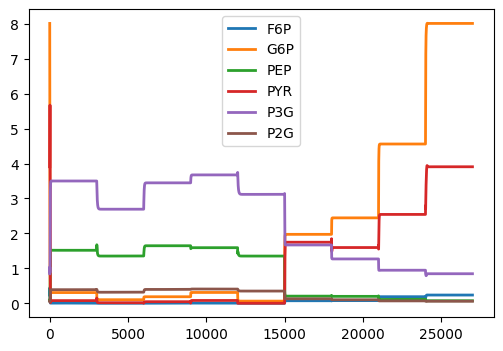

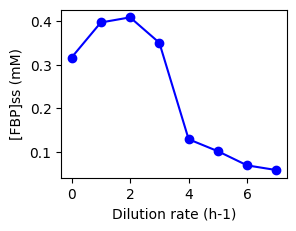

In [ ]:


# simulation
result = r.simulate(0, 27000, 27001)
r.plot(result)

# plot 
all_id = ["time","[GLCi]","[G6P]","[F6P]","[F16BP]","[AMP]","[GLYCERAL3P]","[DHAP]","[NADH]","[P3G]","[P2G]","[PEP]","[PYR]","[GLYC3P]","[G1P]"];
time_points = [6000,9000,12000,15000,18000,21000,24000,27000];
time = result[:,0];
met = result[:,6];
time_array = time[time_points];
met_array = met[time_points];

plt.figure()
plt.subplot(221)
plt.xlabel('Dilution rate (h-1)')
plt.ylabel('[FBP]ss (mM)')
plt.plot(met_array,'bo-')